# Information gain - mutual information

Mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on Y.

As extracted from [wikipedia](https://en.wikipedia.org/wiki/Mutual_information):

Mutual information measures the information that X and Y share: It measures how much knowing one of these variables reduces uncertainty about the other. For example, if X and Y are independent, then knowing X does not give any information about Y and vice versa, so their mutual information is zero. At the other extreme, if X is a deterministic function of Y and Y is a deterministic function of X then all information conveyed by X is shared with Y: knowing X determines the value of Y and vice versa. As a result, in this case the mutual information is the same as the uncertainty contained in Y (or X) alone, namely the entropy of Y (or X). Moreover, this mutual information is the same as the entropy of X and as the entropy of Y. (A very special case of this is when X and Y are the same random variable.)

I will demonstrate how to select features based on mutual information using sklearn on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

### GLOBAL VARIABLES

In [2]:
INPUT_PATH = '../../data/train_test'
OUTPUT_PATH = '../../data/features'
INPUT_FILE_NAME = 'filter_basic_correlation_selected_v006'
OUTPUT_FILE_NAME = 'filter_basic_ig_selected_v006'
SEED = 47
TOP_IG = 30

### FUNCTIONS

In [3]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

### LOAD DATASET

##### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# load dataset 
X_train = pd.read_pickle(f'{INPUT_PATH}/X_train.pkl').pipe(reduce_mem_usage)
y_train = pd.read_pickle(f'{INPUT_PATH}/Y_train.pkl')

In [5]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (20580750, 81)
y_train:  (20580750,)


In [6]:
features = np.load(f'{OUTPUT_PATH}/{INPUT_FILE_NAME}.npy').tolist()

In [7]:
X_train = X_train[features]

In [8]:
X_train['demand'] = y_train.values

### SAMPLE DATASET

In [9]:
X_train = X_train.sample(frac=0.01, replace=True, random_state=SEED)

In [10]:
y_train = X_train.demand

In [12]:
X_train.drop('demand', axis=1, inplace=True)

In [13]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (205808, 38)
y_train:  (205808,)


In [14]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(X_train.select_dtypes(include=numerics).columns)
X_train = X_train[numerical_vars]

In [15]:
print("X_train: ", X_train.shape)

X_train:  (205808, 25)


In [16]:
catfeatures = set(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month', 'week', 'year'])

### MUTUAL INFORMATION CLASSIFICATION

In [17]:
# calculate the mutual information between the variables and the target
# this returns the mutual information value of each feature
# the smaller the value the less information the feature has about the
# target
mi = mutual_info_classif(X_train.fillna(0), y_train)
mi

ValueError: Unknown label type: 'continuous'

In [7]:
# let's add the variable names and order the features
# according to the MI for clearer visualisation
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)

v50     0.039098
v10     0.025009
v14     0.022634
v62     0.021838
v12     0.017273
v129    0.013331
v21     0.011695
v114    0.009943
v34     0.008478
v7      0.008113
v128    0.008042
v101    0.007652
v49     0.007599
v99     0.007561
v65     0.007542
v93     0.007490
v109    0.007451
v13     0.007226
v89     0.007206
v63     0.007198
v100    0.007175
v40     0.007149
v82     0.007060
v122    0.006927
v126    0.006809
v105    0.006696
v61     0.006567
v123    0.006319
v64     0.006239
v43     0.006173
          ...   
v5      0.002967
v124    0.002949
v32     0.002881
v17     0.002813
v81     0.002699
v28     0.002606
v59     0.002588
v77     0.002563
v80     0.002438
v58     0.002423
v68     0.002382
v97     0.002216
v55     0.002088
v37     0.001999
v95     0.001838
v38     0.001821
v108    0.001797
v78     0.001721
v27     0.001708
v96     0.001485
v86     0.001458
v115    0.001407
v1      0.001250
v131    0.001189
v92     0.001041
v18     0.000829
v53     0.000827
v20     0.0000

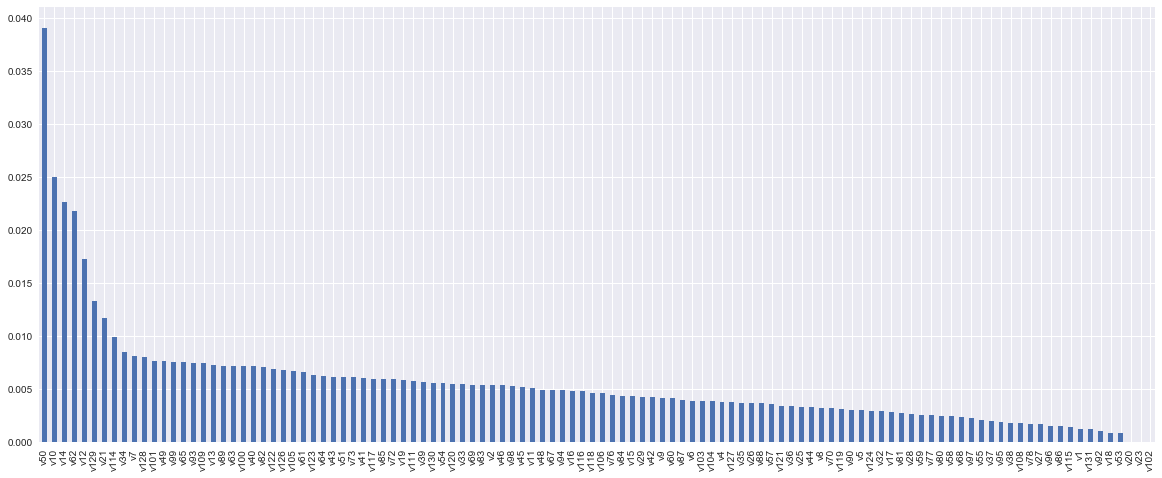

In [9]:
# and now let's plot the ordered MI values per feature
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

Comparatively, we can see that there are a few features (left of the plot) that seem to contribute the most to predicting the target.There are also a few features with almost zero MI values on the right of the plot.

As I explained in the previous lecture, where to put the cut-off to select features is arbitrary. One could choose a certain value of MI after studying the plot above. An alternative and most frequent way of selecting features is to select the top 10, or top 20 features, or the features in the the top 10th percentile of the MI value distribution.

To do this, you can use mutual info in combination with SelectKBest or SelectPercentile from sklearn. SelectKBest allows you to determine how many features, and SelectPercentile the features within a certain percentile. See below.

In [10]:
# here I will select the top 10 features
# which are shown below
sel_ = SelectKBest(mutual_info_classif, k=10).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

Index(['v10', 'v12', 'v14', 'v21', 'v33', 'v34', 'v50', 'v62', 'v114', 'v129'], dtype='object')

In [17]:
X_train.head()

item_id  dept_id  cat_id  store_id  state_id  \
item_id store_id                                                          
0       0        11148763        0        0       0         0         0   
                 12551302        0        0       0         0         0   
                 5081251         0        0       0         0         0   
                 10721901        0        0       0         0         0   
                 17612641        0        0       0         0         0   

                           wm_yr_wk  event_name_1  event_type_1  snap_CA  \
item_id store_id                                                           
0       0        11148763     11517           NaN           NaN        0   
                 12551302     11523           NaN           NaN        1   
                 5081251      11440           NaN           NaN        1   
                 10721901     11515           NaN           NaN        1   
                 17612641     11547           NaN           NaN        0   

                           snap_TX  ...  demand_smoothed_rolling_kurt_t90  \
item_id store_id                    ...                                     
0       0        11148763        0  ...                          0.273556   
                 12551302        0  ...                         -0.222237   
                 5081251         1  ...                         -0.026143   
                 10721901        1  ...                          0.113954   
                 17612641        0  ...                         -0.162954   

                           demand_smoothed_rolling_kurt_t120  \
item_id store_id                                               
0       0        11148763                          -0.540594   
                 12551302                          -0.001018   
                 5081251                            0.440078   
                 10721901                           1.591672   
                 17612641                          -0.177000   

                           demand_smoothed_rolling_kurt_t180  year  quarter  \
item_id store_id                                                              
0       0        11148763                           1.305202  2015        2   
                 12551302                           2.111987  2015        3   
                 5081251                                 NaN  2014        4   
                 10721901                           1.119177  2015        2   
                 17612641                          -0.175196  2015        4   

                           month  week  day  dayofweek  is_weekend  
item_id store_id                                                    
0       0        11148763      5    21   23          5           1  
                 12551302      7    28    8          2           0  
                 5081251      11    45    5          2           0  
                 10721901      5    19    9          5           1  
                 17612641     12    52   21          0           0  

[5 rows x 38 columns]

### MUTUAL INFORMATION REGRESSION

In [ ]:
# determine the mutual information
mi = mutual_info_regression(X_train.fillna(0), y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)

In [ ]:
mi.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [16]:
# here I will select the top 10 percentile
sel_ = SelectPercentile(mutual_info_regression, percentile=10).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

C:\Users\Sole\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars'], dtype='object')

I have not personally used mutual information in any of my projects. However, there is some value in the method. See for example:

Comparison between univariate and mutual information selection in [sklean website](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)

In addition, mutual information has been widely covered, if anything else from a theoretical perspective, in several articles that I share in the additional reading resources section. Therefore I wanted to have it covered in the course, and I leave it up to you to explore it and see if you find any use in it.

That is all for this lecture, I hope you enjoyed it and see you in the next one!